# Austin's MLS Stadium Citizens Comments

When the City of Austin (CoA) was deciding whether to accept the proposal to build an MLS Stadium in the city, the Parks and Recreation department used it's SpeakUp Austin platform to collect comments from its citizens. 

At The Pulse of Austin, we were interested in analyzing this data. More importantly, we were interested to see if machine learning practices could be used to automate the analysis process. If so, could we develop a pipeline that took citizens comments on other issues to quickly and intelligently take the city's pulse? Specifically, we wanted to answer the following questions:
1. Could a model be trained to perform a sentiment analysis on the comments?
2. Could comments be categorized to make it easier for city staff to study them?
3. Can a model be trained to coherently summarize comments?

The ultimate question, however, is if any of these efforts would result in more efficient ways of understanding the citizen's comments. Can we reduce the workload of city staff and still provide good results? Let's find out.

## TO DOS:
1. add a k-means to group comments
2. Add conclusions:
    - more data specific to citizens and their thoughts about city projects would be highly beneficial

### The code below allows for code in this notebook/kernel to be hidden

In [1]:
from IPython.display import HTML

HTML('''<script>code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();}
 code_show = !code_show} $( document ).ready(code_toggle);</script>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

 ## 1. Load Libraries and Data 
 ### Libraries and Set-up

In [2]:
# Accessing Files
import os
dir_path = os.path.dirname(os.path.abspath("__file__")) # To get path to this folder
import pickle

# Tables and Arrays
from pandas import ExcelWriter
import numpy as np
import pandas as pd

# Web Scrapping
from bs4 import BeautifulSoup
import requests
import lxml
from urllib.request import urlopen

# NLP
import nltk
from keras import preprocessing
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
import nltk.corpus  
from nltk.text import Text  
# Spacy
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Neural Networks
from keras.models import Model
from keras import Input, layers
from keras.layers import LSTM
from keras.layers import Embedding, Flatten, Dense, GRU, BatchNormalization, Conv1D
from keras.layers import Concatenate, Dropout, SpatialDropout1D, MaxPool1D
from keras.models import Sequential

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# Evaluate
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Make results reproducible across different model runs
np.random.seed(42)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

c:\users\dbejarano\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\dbejarano\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\dbejarano\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
c:\users\dbejarano\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection 

### Import Data:
Data was obtained from speakupaustin.com. I then manually classified the comments as those against the stadium (-1), neutral (0), and comments that support the project (1).

In [3]:
# Create variable with file paths
comments_file = dir_path + "\MLS Labeled Comments.csv"
zips_file = dir_path + "\MLS Survey Zip Codes.csv"

# Open and read files, then convert to dataframe
comments = pd.read_csv(comments_file, encoding="ISO-8859-1")
zips = pd.read_csv(zips_file)

# Remove "NA"
comments.dropna(inplace=True)
comments.drop('Question', inplace=True, axis=1) # The Question column does not provide useful information
zipcodes = zips.dropna()

# Show Results
display(comments.head(3))
print("Number of Comments: {}".format(comments.shape[0]))
display(zipcodes.head(3))
print("Number of Zip Codes: {}".format(zipcodes.shape[0]))

,Comment,Manual
0,Increased neighborhood walkability,0
1,Pro sports deserve no public funds; they are a...,-1
2,All of these internet responses shouldn't coun...,0


Number of Comments: 220


,Zip Codes
0,78741
1,78758
2,78757


Number of Zip Codes: 163


## 2. Exploratory Data Analysis
### Zipcodes
We have 220 comments from citizens, of which only 163 provided their zip code. Since we don't have a way of linking comments to zip codes, the only analysis we will do on the zipcodes will be to determine how well represented they were (i.e. how many comments came from each one).

To do that, we will pull zip code information, including coordinates and population, from the following source:
http://zipatlas.com/us/tx/austin/zip-code-comparison/population-density.htm

#### Create dataframe with zip codes, # of comments from each zip code, population, latitude and longitude

In [4]:
# Create data frame that has a set of unique zip codes and the count of comments from each 
zipcode_counts = pd.DataFrame(zipcodes['Zip Codes'].value_counts()).reset_index(drop=False)
zipcode_counts.columns = ['Zip Code', 'Count']

# # Import Zip Code Coordinates File
# zipcode_coordinates = dir_path + "\Zip Code Coordinates.xlsx"
# zipcode_coor = pd.read_excel(zipcode_coordinates)

# Get Table with Zip Codes, Coordinate and Population
url = 'http://zipatlas.com/us/tx/austin/zip-code-comparison/population-density.htm'

html = requests.get(url).content #get data using the generated URL
zip_table = pd.read_html(url)[0][15:59]
zip_table.columns = zip_table.iloc[0]
zip_table = zip_table.iloc[1:]
zip_table.reset_index(drop=True, inplace=True)
zip_table.drop(zip_table.columns[6:], inplace=True, axis=1)
zip_table.drop('#', axis=1, inplace=True)

split_loc = zip_table['Location'].apply(lambda x: x.split(","))
zip_table['Latitude'] = split_loc.apply(lambda x: x[0])
zip_table['Longitude'] = split_loc.apply(lambda x: x[1])
zip_table.drop(['Location', 'City'], inplace=True, axis=1)
# zip_table = zip_table.convert_objects(convert_numeric=True)
# Convert Values to Numeric 
for col in zip_table.columns:
    zip_table[col] = pd.to_numeric(zip_table[col])

# Add coordinates to Austin zip codes
atx_zips = zip_table[zip_table['Zip Code'].isin(zipcode_counts['Zip Code'])]
# atx_zips = atx_zips[atx_zips['Zip Code'] != 35111]

# Merge the two dataframes to consolidate zip codes, count, lat and lon
atx_zips = zipcode_counts.merge(atx_zips, on='Zip Code')

#### Plot observations by zip code

c:\users\dbejarano\anaconda3\lib\site-packages\ipykernel\__main__.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


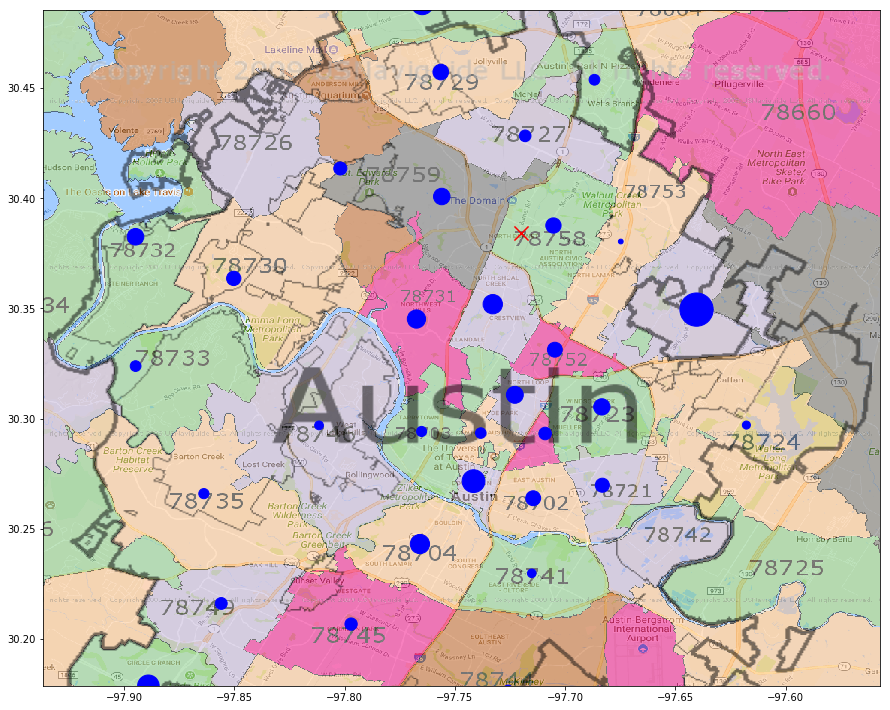

In [5]:
# import image of Austin Zip Code Map
from scipy.misc import imread
import matplotlib.cbook as cbook

# estimated latitude (N, S) and longitude (E, W) from looking at a map
# Source: http://www.mapcoordinates.net/en
y1 = 30.17881603
x1 = -97.93701039
y2 = 30.48521701
x2 = -97.55729543

# Other parameters for plot
lat = atx_zips['Latitude']
lon = atx_zips['Longitude']
marker = atx_zips['Count'] / atx_zips['Population'] * 1000000

# Plot count per zip code and overlay it on zip code image
zipcodes_map = dir_path + "\Atx zipcodes map.png"
map_file = cbook.get_sample_data(zipcodes_map)
img = imread(map_file)
plt.figure(figsize = (15,20))
plt.scatter(lon, lat, c='b', s=marker, marker='o')

# Add Stadium Proposed Location
plt.scatter(-97.719913, 30.384220, c='red', s=200, marker='x')

# Show Plot
plt.imshow(img, zorder=0, extent=[x1, x2, y1, y2])
plt.show()

##### Analysis:
From the image above we see the blue circles representing the proportion of the 220 comments that came from each zip code, normalized by the zip code's population so that it represents comments per capita. There's not much we can infer, other than that there were comments from almost all zip codes.

We can also see the proposed stadium location marked with a red "X". When we plot (which is not shown here) the number of comments per zip code, without dividing by the population, we notice that some of the zip codes with the most comments are those around the "X". However, once we divide by population it doesn't appear like the zip codes around the proposed location were more participative in comparison to the rest.

### Text Preprocessing

In [6]:
# Define function to process text
def text_process(mess):# mess stands for message
    '''
    1. Remove punctuation
    2. Remove Stop Words
    3. Return list of cleaned text words
    '''
    nopunc = [c for c in mess if c not in string.punctuation]
    nopunc = "".join(nopunc) # to join together separated characters back into words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in nopunc.split() if w.lower() not in stopwords.words('english')] # returns a list of list of words
    cleaned_sent = " ".join(lemmatized_words) # returns a list of sentences
    return(cleaned_sent)

In [7]:
clean_comments = [text_process(mess) for mess in comments['Comment']]
labels = comments['Manual']
clean_comments[0]

'Increased neighborhood walkability'

### Text Analysis

#### Split into Train and Test

In [8]:
# Create new variable measuring the length of each question
clean_comments_df = pd.DataFrame(clean_comments, columns=['Comment'])
clean_comments_df['Length'] = clean_comments_df['Comment'].apply(lambda x: len(x.split()))
clean_comments_df['Label'] = comments['Manual'].copy()

train_df, test_df = train_test_split(clean_comments_df, test_size=0.2)

#### Check Proportion of Labels
We see below that almost half of the comments are negative. The rest are almost equally split between neutral and positive comments. This is therefore an imbalanced dataset.

[Text(0.5,1,'Comment Labels')]

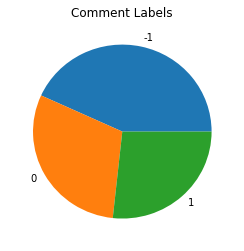

In [9]:
fig, axes = plt.subplots(figsize=(4, 4))
axes.pie(train_df['Label'].value_counts(), labels=np.unique(train_df['Label']))
axes.set(title='Comment Labels')

#### Plot Question Length

c:\users\dbejarano\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5,0,'Number of Words'),
 Text(0.5,1,'Distribution of Question Length by label Group: Blue=Sincere | Orange=Insincere')]

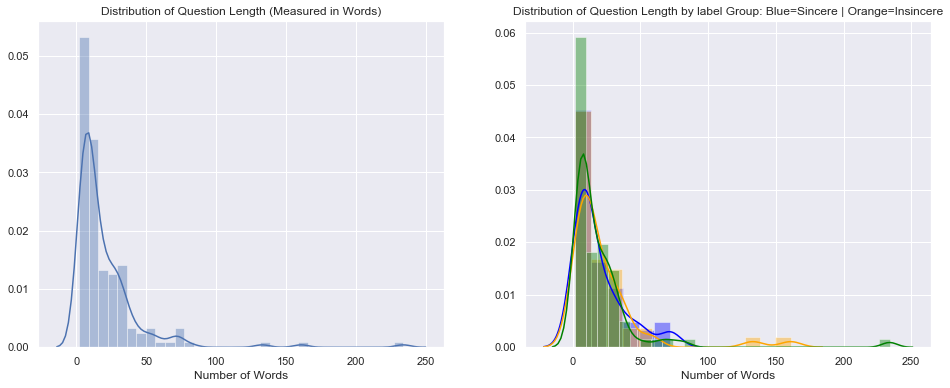

In [10]:
# Plot distribution of question lengths
sns.set()
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 6)
sns.distplot(train_df['Length'], ax=axes[0])
axes[0].set(xlabel='Number of Words', title='Distribution of Question Length (Measured in Words)')
sns.distplot(train_df['Length'][train_df['Label']==0], ax=axes[1],color='blue')
sns.distplot(train_df['Length'][train_df['Label']==1], ax=axes[1],color='orange')
sns.distplot(train_df['Length'][train_df['Label']==-1], ax=axes[1], color='green')
axes[1].set(xlabel='Number of Words', title='Distribution of Question Length by label Group: Blue=Sincere | Orange=Insincere')

#### TF-IDF and Word Count Analysis

[Text(0.5,0,' # Of Occurrences'), Text(0.5,1,'Most Common Words')]

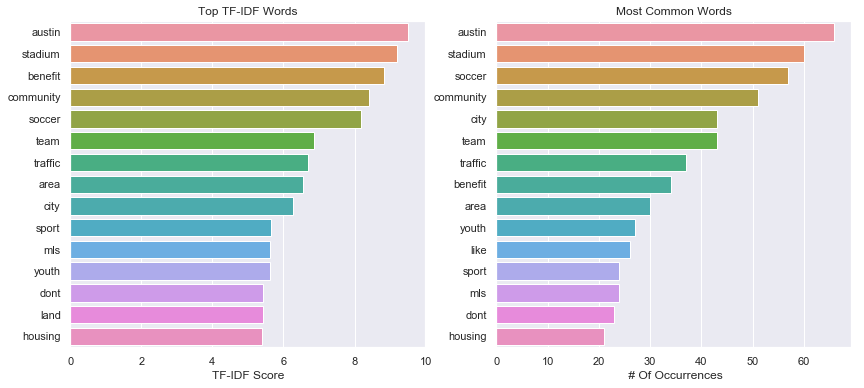

In [11]:
# Define Function to Get TF-IDF Scores and Counts

def get_word_scores(train_data, test_data, vectorizer): 
    ''' Function to vectorize data and get words scores. In this particular case
    we are using it for tf-idf scores and word counts. 
    The reason to include the test data, which is not immediately apparent, is that one of the classifiers in our
    sentiment analysis will be based off the tf-idf and count vectors.
    Input: training list of sentences, test list of sentences, and the vectorizer to use (e.g. CountVectorizer)
    Outpout: train and test observations in tf-idf scores form, word score, and the fitted vectorizer '''
    
    # Fit vectorizer to train data. Transform train and test sets
    vectorizer.fit(train_data)
    x_train =  vectorizer.transform(train_data) 
    x_test = vectorizer.transform(test_data)

    # Highest TF-IDF Scores
    vocab = vectorizer.vocabulary_ # gives the number of words in our vocabulary
    sum_words = x_train.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in vocab.items()], 
                        key=lambda x: x[1], reverse=True)
    return(x_train, x_test, words_freq, vectorizer)


### TF-IDF ###
tf_vectorizer = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word',
            ngram_range=(1, 1), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

X_train_tf, X_test_tf, tf_scores, tf_model = get_word_scores(train_df['Comment'], test_df['Comment'], tf_vectorizer)


### WORD COUNT ###
count_vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')

X_train_ct, X_test_ct, words_count, count_model = get_word_scores(train_df['Comment'], test_df['Comment'], count_vectorizer)


# Plot TF-IDF and Word Counts
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(14, 6)
sns.barplot(y=np.array(tf_scores)[:15, 0], x=np.array(tf_scores)[:15, 1].astype(float), ax=axes[0])
axes[0].set(xlabel='TF-IDF Score', title='Top TF-IDF Words')
sns.barplot(y=np.array(words_count)[:15, 0], x=np.array(words_count)[:15, 1].astype(int), ax=axes[1])
axes[1].set(xlabel=' # Of Occurrences', title='Most Common Words')

##### Analysis:
The bar plots above show which words have the highest tf-idf scores and also those words that occur most often. It gives us  a good idea of what things citizens focused on. 

#### Word Cloud

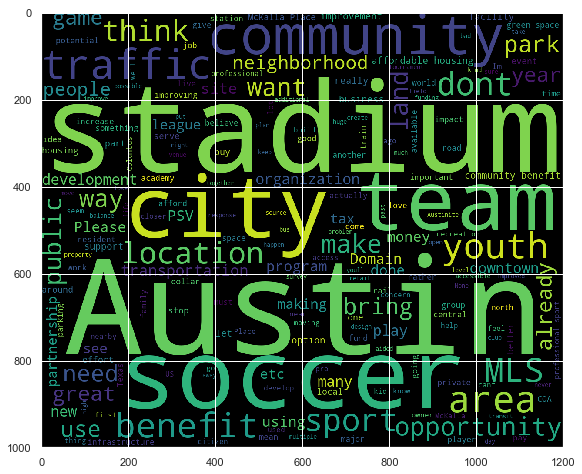

In [12]:
all_sentences = " ".join(list(train_df['Comment']))
              
wordcloud = WordCloud(max_font_size=None, background_color='black',
                      width=1200, height=1000).generate(all_sentences)
fig = plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)

##### Analysis:
We can infer from the wordcloud above what the main themes were in the citizen's comments. One observation to make is that from scanning the words we see that most of them are either neutral or positive. This does not necessarily mean that comments were mainly positive (as we saw earlier they were pretty balanced) but gives us an idea that negative comments were not too negative, or at least not aggressively negative, as aggressively negative words are not present. 

#### Tokenize

In [13]:
# Look at the longest comments
train_df.sort_values(by='Length', ascending=False).head()

# Define sentence and vocabulary sizes
max_len = 80
max_words = 10000 # only the 10,000 most common words will be used

# Tokenize Words
train_tokens = [nltk.word_tokenize(sent) for sent in train_df['Comment']]
test_tokens = [nltk.word_tokenize(sent) for sent in test_df['Comment']]

In [14]:
def tokenize_and_pad(train_data, test_data, max_words):

    '''Takes the training and testing dataframes, as well as the desired vocab size as input and returns:
    1. tokenized, padded train comments
    2. tokenized, padded test comments
    3. train labels
    4. test labels
    5. the word_index to associate numerical vectors to sentences'''
    
    tokenizer = Tokenizer(num_words=max_words) 
    tokenizer.fit_on_texts(train_data['Comment']) # creates a list of tokens (words) of the 10000 most common words on "texts"
    train_tokens = tokenizer.texts_to_sequences(train_data['Comment']) # converts "texts" into sequences of tokens for the 10000 most common words
    test_tokens = tokenizer.texts_to_sequences(test_data['Comment'])

    word_index = tokenizer.word_index
    train_padded = pad_sequences(train_tokens, maxlen=max_len)
    train_labels = np.asarray(train_data['Label'])
    test_padded = pad_sequences(test_tokens, maxlen=max_len)
    test_labels = np.asarray(test_data['Label'])

    return(train_padded, test_padded, train_labels, test_labels, word_index)


In [15]:
# Get sentence vectors and labels
X_train, X_test, y_train, y_test, word_index = tokenize_and_pad(train_df, test_df, max_words)

#### Named Entity Recognition

To better understand what the citizen's focused on in their comments, we perform a Named Entity Recognition (NER) analysis.  The figures below make it easy to scan the text, from which we can see that no surprises were present.

##### Sources:
- https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da
- https://spacy.io/api/annotation#named-entities

In [16]:
# # Get Entities
nlp = en_core_web_sm.load()
all_comments = nlp(" ".join(train_df['Comment']))
labels = [x.label_ for x in all_comments.ents]
items = [x.text for x in all_comments.ents]

# Show most common entities
print(Counter(labels))
print(Counter(items).most_common(10))

Counter({'ORG': 95, 'PERSON': 77, 'GPE': 44, 'CARDINAL': 22, 'DATE': 21, 'NORP': 9, 'ORDINAL': 7, 'FAC': 5, 'PRODUCT': 5, 'LOC': 4, 'TIME': 2, 'WORK_OF_ART': 1})
[('Austin', 39), ('MLS', 20), ('PSV', 8), ('Domain', 6), ('one', 6), ('Columbus', 6), ('COA', 5), ('McKalla Place', 5), ('first', 4), ('East Austin', 4)]


In [17]:
# Display
displacy.render(all_comments, jupyter=True, style='ent')

In [18]:
# Display a Sentence Example
displacy.render(nlp(str(train_df['Comment'][17])), style='dep', jupyter = True, options = {'distance': 120})

#### Most Common Combination of Words

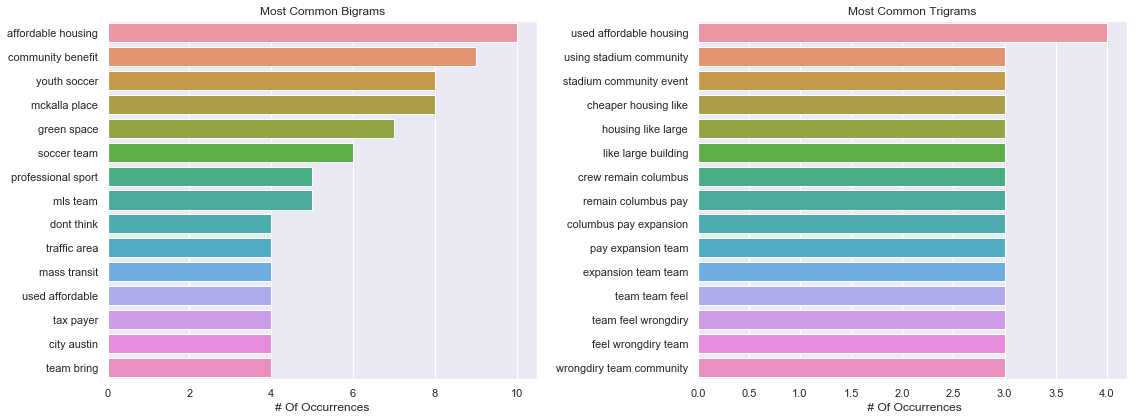

In [19]:
### BIGRAM AND TRIGRAM COUNT ###
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
train_bigrams, test_bigrams, bigram_count, bigram_model = get_word_scores(train_df['Comment'], 
                                                                          test_df['Comment'], bigram_vectorizer)

trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
train_trigrams, test_trigrams, trigram_count, trigram_model = get_word_scores(train_df['Comment'], 
                                                                              test_df['Comment'], trigram_vectorizer)


# Plot TF-IDF and Word Counts
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(16, 6)
sns.barplot(y=np.array(bigram_count)[:15, 0], x=np.array(bigram_count)[:15, 1].astype(float), ax=axes[0])
axes[0].set(xlabel='# Of Occurrences', title='Most Common Bigrams')
sns.barplot(y=np.array(trigram_count)[:15, 0], x=np.array(trigram_count)[:15, 1].astype(int), ax=axes[1])
axes[1].set(xlabel=' # Of Occurrences', title='Most Common Trigrams')

plt.tight_layout()

##### Analysis:
We can infer from the biggrams and trigrams what some of the contentious topics were. For instance, affordable housing, mass transit, tax payer and green spaces are all public or personal topics that usually come up in public projects.

#### What BENEFIT do citizens see on the MLS Stadium

In [20]:
combined_comments = [w for c in train_tokens for w in c]
comments_text = nltk.Text(combined_comments)
comments_text.concordance('benefit')

# Show the context around "benefit" utilizing regular expressions
comments_text.findall(r"<.*> <.*> <benefit> <.*>")

# Show what words appear in a similar context as "benefit"
comments_text.similar("recognized")

Displaying 25 of 25 matches:
ge person would comprehend question benefit Donate want area already congested 
y gathering etc COA park would want benefit balance inconvenience crowd traffic
ion would great course designed way benefit live music event Would help retail 
ically underserved community Austin benefit soccer program equipment new improv
ey use affordable housing community benefit PSV stadium brings none thing hando
ternet response invalid seem little benefit everyday person pulling traffic alr
green space would included way site benefit nearby neighborhood year round see 
hood year round see MLS stadium lot benefit city skeptical McKalla appropriate 
sored youth academy team would huge benefit deserving youth may able afford top
Help bring development youth soccer benefit group Making stadium part nearby ne
aid infrastructure choice community benefit rather potential problem profession
 looking Austin influence dont find benefit area Using stadium community event 
urchasing t

## 3. Sentiment Analysis
### Approach A: Classify Using Only TF-IDF Scores

##### Source: 
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

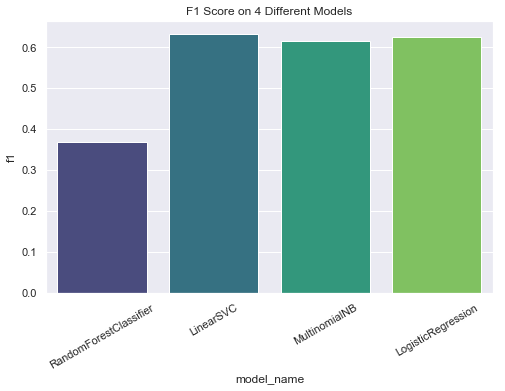

In [21]:
# Models to fit
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
]

# Convert sparse matrix into dense
X_train_tf_dense = X_train_tf.toarray()

# Set parameters for cross vlaidation
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# Fit models
for model in models:
    model_name = model.__class__.__name__
    y_pred = cross_val_predict(model, X_train_tf_dense, y_train, cv=10)
    f1 = f1_score(y_train, y_pred, average='macro')
    entries.append((model_name, f1))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'f1'])
   

# Plot F1 scores
fig, axes = plt.subplots(figsize=(8, 5))
sns.barplot(x='model_name', y='f1', data=cv_df, palette='viridis')
axes.set_xticklabels(rotation=30, labels=cv_df['model_name'])
axes.set(title="F1 Score on 4 Different Models")
plt.show()

#### Predict and Evaluate on Test Set

In [22]:
svc_model = LinearSVC()

svc_model.fit(X_train_tf, y_train)
final_pred = svc_model.predict(X_test_tf)

print("TEST SET CLASSIFICATION REPORT: \n", classification_report(y_test, final_pred))

TEST SET CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         -1       0.48      0.80      0.60        15
          0       0.50      0.24      0.32        17
          1       0.55      0.50      0.52        12

avg / total       0.51      0.50      0.47        44



##### Analysis:
After trying different combination of # of n_grams, as well as tuning other hyperparameters, the best performing model using cross validation, based on F1 Score is Linear SVC with n_grams of just one word. 

We see from the classification report above that precision, recall and f1-scores are all around 50. This is not much better than random guessing. Meaning the model is not doing too good of a job, so let's try a more complex model now using word embeddings.

### Approach B: Classify Using Pre-Learned Word Embeddings and Training on Comments

In [23]:
# Load Embeddings File From Computer
glove_dir = r'C:\Users\dbejarano\Dropbox\Data Analytics Projects\03 Pre-Trained Basis'

glove_file_path = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Create Embedding Matrix
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embed_size = 100
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(glove_file_path, encoding="utf8"))

nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i-1] = embedding_vector

In [24]:
def assign_embeddings(df, word_index, embeddings_index):
    '''This fuction takes the training and testing datasets (df) and creates a tensor of embeddings
    based on the embeddings_index and vocab_index provided. 
    - vocab_index is the index containing all words in the vocabulary that were generated by the tokenizer
    - embeddings_index is the index GloVe (or other) list of embeddings'''
    df_embeddings = []
    embeddings_size = embeddings_index['a'].shape[0]
    for i in df:
        sentence_embeddings = np.zeros((max_len+1, embeddings_size)) # creates a 300 by 65 matrix
        non_zeros = np.count_nonzero(i)
        for j, k in enumerate(i):
            if k != 0:
                try:
                    word = list(word_index.keys())[list(word_index.values()).index(k)]
                    sentence_embeddings[j] = embeddings_index[word]
                except:
                    sentence_embeddings[j] = np.zeros(embeddings_index['a'].shape[0])
            elif j == len(i)-1:
                sentence_embeddings[j] = np.array(np.full(embeddings_size, non_zeros))
            else: sentence_embeddings[j] = np.zeros(embeddings_index['a'].shape[0]) 

        df_embeddings.append(sentence_embeddings)       
        
    return(df_embeddings)

In [25]:
# Create 3D array with embeddings for all observations
train_embeddings = np.asarray(assign_embeddings(X_train, word_index, embeddings_index))
test_embeddings = np.asarray(assign_embeddings(X_test, word_index, embeddings_index))

print('Train Embeddings Size: {}'.format(train_embeddings.shape))
print('Test Embeddings Size: {}'.format(test_embeddings.shape))

Train Embeddings Size: (176, 81, 100)
Test Embeddings Size: (44, 81, 100)


#### Convert word vector sentences to sentence vectors using Doc2vec

##### Sources:
https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb

Doc2vec requires a list of tagged sentences, not just a list of sentences, so we will be tagging our train tokens.

In [26]:
train_tagged = [TaggedDocument(sentence, 'tag') for sentence in train_tokens]

model = Doc2Vec(train_tagged, vector_size=max_len, min_count=2, epochs=40)

train_doc_vectors = [model.infer_vector(x) for x in train_tokens]
test_doc_vectors = [model.infer_vector(x) for x in test_tokens]

#### Train on Word Embeddings

RandomForestClassifier
LinearSVC
LogisticRegression


c:\users\dbejarano\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


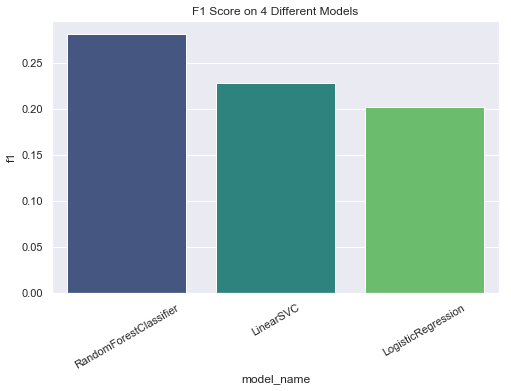

In [27]:
# Models to fit
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    #MultinomialNB(),
    LogisticRegression(),
]

# Set parameters for cross vlaidation
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# Fit models
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    y_pred = cross_val_predict(model, train_doc_vectors, y_train, cv=10)
    f1 = f1_score(y_train, y_pred, average='macro')
    entries.append((model_name, f1))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'f1'])
   
# Plot F1 scores
fig, axes = plt.subplots(figsize=(8, 5))
sns.barplot(x='model_name', y='f1', data=cv_df, palette='viridis')
axes.set_xticklabels(rotation=30, labels=cv_df['model_name'])
axes.set(title="F1 Score on 4 Different Models")
plt.show()

### Approach C: Classify by Training on Movie Reviews

For this approach, since movies are reviewed as either positive or negative (no neutral), we will reclassify our neutral comments on the MLS stadium as positive. More specifically, we will be classifying comments as negative or non-negative.

We will consider two models:
1. A SVC using tf-idf scores
2. Training a neural network using word embeddings

#### Load movie reviews

In [28]:
pos_path = os.path.join(dir_path, "Movie Reviews", "Pos")
neg_path = os.path.join(dir_path, "Movie Reviews", "Neg")

pos_files = []
neg_files = []

for fname in os.listdir(pos_path):
    with open(os.path.join(pos_path, fname), 'r', encoding="ISO-8859-1") as myfile:
        pos_files.append(myfile.read())
        
for fname in os.listdir(neg_path):
    with open(os.path.join(neg_path, fname), 'r', encoding="ISO-8859-1") as myfile:
        neg_files.append(myfile.read())     
        
print(' Number of Positive Reviews: {}'.format(len(pos_files)), '\n', 
      'Number of Negative Reviews: {}'.format(len(neg_files)))

 Number of Positive Reviews: 12500 
 Number of Negative Reviews: 12500


####  Clean movie review

In [29]:
clean_pos_reviews = [text_process(review) for review in pos_files]
clean_neg_reviews = [text_process(review) for review in neg_files]

print("Average + Review Length: {}".format(np.mean([len(comment.split(" ")) for comment in clean_pos_reviews])))
print("Average - Review Length: {}".format(np.mean([len(comment.split(" ")) for comment in clean_neg_reviews])))

Average + Review Length: 126.16912
Average - Review Length: 122.35968


#### Tokenize and pad movie reviews

In [30]:
# Define sentence and vocabulary sizes
max_len = 150
max_words = 15000 # only the 15,000 most common words will be used

# Create DataFrame w/ Comments & Labels Columns need to be named Comment and Label, since tokenize_and_pad uses those names
reviews_df = pd.DataFrame()
reviews_df['Comment'] = clean_pos_reviews + clean_neg_reviews
reviews_df['Label'] = None
reviews_df['Label'][:len(clean_pos_reviews)] = 1
reviews_df['Label'][len(clean_pos_reviews):] = -1

# We tokenize and pad to use the resulting vectors in our neural network
# We add the comments we will test on, so that the vocabulary size is the same
reviews_X_train_val, comments_X_test, reviews_y_train_val, comments_y_test, reviews_word_index = tokenize_and_pad(reviews_df, 
                                                                                clean_comments_df.drop('Length', axis=1),
                                                                                max_words)

reviews_X_train, reviews_X_val, reviews_y_train, reviews_y_val = train_test_split(reviews_X_train_val, 
                                                                                  reviews_y_train_val, test_size=0.20)

#### Create TF-IDF vectors

In [31]:
### TF-IDF ###
reviews_tf_vectorizer = TfidfVectorizer(min_df=3, max_features=max_words, strip_accents='unicode', analyzer='word',
            ngram_range=(1, 1), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

reviews_X_train_val_tf, comments_test_tf, reviews_tf_scores, reviews_tf_model = get_word_scores(reviews_df['Comment'], 
                                                                            clean_comments_df['Comment'], 
                                                                            reviews_tf_vectorizer)

reviews_X_train_tf, reviews_X_val_tf, reviews_y_train_tf, reviews_y_val_tf = train_test_split(reviews_X_train_val_tf, 
                                                                                  reviews_df['Label'], test_size=0.20)

#### Change neutral comments labels to positive (i.e. change 0 to 1) and make negative labels equal to 0

In [67]:
y_train_pn = y_train.copy()
y_train_pn[y_train_pn == 0] = 1

y_test_pn = y_test.copy()
y_test_pn[y_test_pn ==0] = 1

y_pn = clean_comments_df['Label'].copy()
y_pn[y_pn == 0] = 1
y_pn[y_pn == -1] = 0

reviews_y_train[reviews_y_train == -1] = 0
reviews_y_val[reviews_y_val == -1] = 0

reviews_y_train_tf[reviews_y_train_tf == -1] = 0
reviews_y_val_tf[reviews_y_val_tf == -1] = 0

reviews_y = reviews_df['Label']
reviews_y[reviews_y == -1] = 0

In [68]:
# Check that all labels are now 0 and 1
print(np.unique(reviews_y_val, return_counts=True))
print(np.unique(y_pn, return_counts=True))
print(np.unique(pred_cnn, return_counts=True))
print(np.unique(reviews_y_train_tf, return_counts=True))
print(np.unique(reviews_y, return_counts=True))

(array([0, 1], dtype=int64), array([2489, 2511], dtype=int64))
(array([0, 1], dtype=int64), array([ 91, 129], dtype=int64))
(array([0, 1]), array([ 71, 149], dtype=int64))
(array([0, 1], dtype=int64), array([10040,  9960], dtype=int64))
(array([0, 1], dtype=int64), array([12500, 12500], dtype=int64))


#### TF-IDF MODELS
Train a SVC and a Naive Bayes model on movie reviews and cross-evaluate on what used to be our training comments. Final evaluation will be performed on the comments test set.

In [69]:
# # SVC
svc_parameters = {'C': [1], 'kernel':['linear']} # chosen based on previous runs

svc_reviews_model = GridSearchCV(SVC(), param_grid=svc_parameters, scoring='accuracy', cv=5, refit=True, verbose=1)
svc_reviews_model = svc_reviews_model.fit(reviews_X_train_val_tf, reviews_df['Label'])
svc_tf_pred = svc_reviews_model.predict(comments_test_tf)
print("SVC MODEL REPORT: {}".format(classification_report(y_pn, svc_tf_pred)))

# NB
nb_parameters = {'alpha':[0.6]} # chosen based on previous runs
nb_reviews_model = GridSearchCV(MultinomialNB(), param_grid=nb_parameters, scoring='accuracy', cv=5, refit=True, verbose=1)
nb_reviews_model = nb_reviews_model.fit(reviews_X_train_val_tf, reviews_df['Label'])
nb_tf_pred = nb_reviews_model.predict(comments_test_tf)
print("NB MODEL REPORT: {}".format(classification_report(y_pn, nb_tf_pred)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.1min finished


SVC MODEL REPORT:              precision    recall  f1-score   support

          0       0.51      0.52      0.51        91
          1       0.66      0.65      0.65       129

avg / total       0.60      0.60      0.60       220

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


NB MODEL REPORT:              precision    recall  f1-score   support

          0       0.56      0.37      0.45        91
          1       0.64      0.79      0.71       129

avg / total       0.61      0.62      0.60       220



In [60]:
# Save SVC Model (NB does not take long to train, so we can just run it again if necessary)
svc_filename = 'svc_on_reviews.sav'
pickle.dump(svc_reviews_model, open(svc_filename, 'wb'))

# # Load Model
# loaded_grid_s = pickle.load(open(svc_filename, 'rb'))s

#### Analysis:
Training our model on TF-IDF scores of movie reviews to then predict the sentiment of citizen's comments provided a result (as measured by f1-score) that is slightly inferior to that of training on the actual citizen's comments.

This brings the following important consideration to light: even though ML models tend to perform better with more data, adding ~25,000 observations did not result in any improvement. This is most likely because natural language models are very task specific. Meaning, differences in the sentence structure of the citizen's comments when compared to movie reviews, or the type of words used, or even the length (we saw how reviews were on average more than twice as long as comments) can greatly affect the patterns and structures learned by the models. 

All this to conclude that so far the best model has been our simple approach of training on TF-IDF scores of only a few number of comments (around 170 in total). Now we will try a neural network to see if we get better results.

#### CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL
Train a neural network on movie reviews using pre-learned word embeddings.

#### Create embeddings matrix

In [61]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(glove_file_path, encoding="utf8"))

nb_words = min(max_words, len(reviews_word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in reviews_word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i-1] = embedding_vector

In [62]:
filter_sizes = [1,2,3]
num_filters = 36

# Build Model
inp = Input(shape=(max_len, ))
x = Embedding(max_words, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.6)(x)

conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]),
                             kernel_initializer='he_normal', activation='elu')(x)
conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), 
                             kernel_initializer='he_normal', activation='elu')(x)

mp_0 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_0)
mp_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
mp_2 = MaxPool1D(pool_size=(max_len - filter_sizes[2] + 1))(conv_2)

conc = Concatenate(axis=1)([mp_0, mp_1, mp_2])   
conc = Flatten()(conc)
conc = BatchNormalization()(conc)

out = Dense(1, activation="sigmoid")(conc)

cnn_model = Model(inputs=inp, outputs=out)

# Compile and Fit
cnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

cnn_hist = cnn_model.fit(reviews_X_train, reviews_y_train, batch_size=512, epochs=10,
                 validation_data=(reviews_X_val, reviews_y_val), verbose=1)

# Save Model
cnn_filename = 'cnn_model.pk'
file_path = os.path.join(dir_path, cnn_filename)
with open(file_path, 'wb') as f:
    pickle.dump(cnn_model, f)

cnn_model.summary()
    
# # Load Model
# loaded_cnn = pickle.load(open(cnn_filename, 'rb'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - ETA: 25:18 - loss: 0.8957 - acc: 0.50 - ETA: 24:02 - loss: 0.8823 - acc: 0.49 - ETA: 22:42 - loss: 0.8683 - acc: 0.49 - ETA: 22:17 - loss: 0.8691 - acc: 0.49 - ETA: 21:40 - loss: 0.8662 - acc: 0.49 - ETA: 21:08 - loss: 0.8614 - acc: 0.49 - ETA: 20:39 - loss: 0.8529 - acc: 0.49 - ETA: 19:53 - loss: 0.8436 - acc: 0.50 - ETA: 19:09 - loss: 0.8391 - acc: 0.50 - ETA: 18:49 - loss: 0.8347 - acc: 0.50 - ETA: 18:20 - loss: 0.8340 - acc: 0.49 - ETA: 17:41 - loss: 0.8313 - acc: 0.50 - ETA: 17:01 - loss: 0.8312 - acc: 0.49 - ETA: 16:26 - loss: 0.8265 - acc: 0.50 - ETA: 15:44 - loss: 0.8240 - acc: 0.50 - ETA: 15:02 - loss: 0.8220 - acc: 0.49 - ETA: 14:21 - loss: 0.8189 - acc: 0.50 - ETA: 13:49 - loss: 0.8165 - acc: 0.50 - ETA: 13:24 - loss: 0.8154 - acc: 0.50 - ETA: 12:49 - loss: 0.8116 - acc: 0.50 - ETA: 12:15 - loss: 0.8080 - acc: 0.50 - ETA: 11:39 - loss: 0.8058 - acc: 0.50 - ETA: 11:07 - 

20000/20000 [==============================] - ETA: 23:56 - loss: 0.6620 - acc: 0.60 - ETA: 23:10 - loss: 0.6614 - acc: 0.60 - ETA: 22:47 - loss: 0.6564 - acc: 0.60 - ETA: 22:21 - loss: 0.6458 - acc: 0.61 - ETA: 22:02 - loss: 0.6496 - acc: 0.61 - ETA: 21:45 - loss: 0.6502 - acc: 0.61 - ETA: 21:16 - loss: 0.6521 - acc: 0.61 - ETA: 20:38 - loss: 0.6479 - acc: 0.62 - ETA: 19:59 - loss: 0.6491 - acc: 0.62 - ETA: 19:27 - loss: 0.6502 - acc: 0.61 - ETA: 18:51 - loss: 0.6486 - acc: 0.62 - ETA: 18:38 - loss: 0.6472 - acc: 0.62 - ETA: 18:09 - loss: 0.6467 - acc: 0.61 - ETA: 17:40 - loss: 0.6457 - acc: 0.61 - ETA: 17:00 - loss: 0.6457 - acc: 0.62 - ETA: 16:21 - loss: 0.6449 - acc: 0.62 - ETA: 15:38 - loss: 0.6430 - acc: 0.62 - ETA: 14:53 - loss: 0.6423 - acc: 0.62 - ETA: 14:08 - loss: 0.6427 - acc: 0.62 - ETA: 13:23 - loss: 0.6432 - acc: 0.62 - ETA: 12:39 - loss: 0.6432 - acc: 0.62 - ETA: 11:54 - loss: 0.6433 - acc: 0.62 - ETA: 11:11 - loss: 0.6432 - acc: 0.62 - ETA: 10:28 - loss: 0.6429 - acc: 

20000/20000 [==============================] - ETA: 28:46 - loss: 0.4860 - acc: 0.76 - ETA: 27:26 - loss: 0.4950 - acc: 0.76 - ETA: 26:36 - loss: 0.5024 - acc: 0.75 - ETA: 25:43 - loss: 0.5070 - acc: 0.75 - ETA: 25:23 - loss: 0.5118 - acc: 0.75 - ETA: 24:41 - loss: 0.5108 - acc: 0.75 - ETA: 24:10 - loss: 0.5152 - acc: 0.74 - ETA: 23:12 - loss: 0.5168 - acc: 0.74 - ETA: 22:12 - loss: 0.5168 - acc: 0.74 - ETA: 21:09 - loss: 0.5204 - acc: 0.74 - ETA: 20:12 - loss: 0.5192 - acc: 0.74 - ETA: 19:19 - loss: 0.5185 - acc: 0.74 - ETA: 18:23 - loss: 0.5179 - acc: 0.74 - ETA: 17:48 - loss: 0.5188 - acc: 0.74 - ETA: 17:00 - loss: 0.5195 - acc: 0.74 - ETA: 16:13 - loss: 0.5196 - acc: 0.74 - ETA: 15:25 - loss: 0.5173 - acc: 0.74 - ETA: 14:39 - loss: 0.5180 - acc: 0.74 - ETA: 13:50 - loss: 0.5183 - acc: 0.74 - ETA: 13:02 - loss: 0.5184 - acc: 0.74 - ETA: 12:17 - loss: 0.5191 - acc: 0.74 - ETA: 11:34 - loss: 0.5182 - acc: 0.74 - ETA: 10:50 - loss: 0.5178 - acc: 0.74 - ETA: 10:10 - loss: 0.5190 - acc: 

220/220 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 1s 4ms/step
Classification Report:  
              precision    recall  f1-score   support

          0       0.68      0.53      0.59        91
          1       0.71      0.82      0.76       129

avg / total       0.70      0.70      0.69       220

[[ 48  43]
 [ 23 106]]


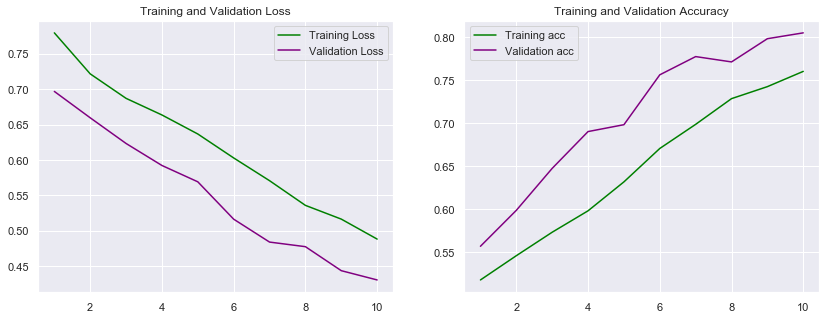

In [63]:
# Predict and Evaluate
pred_cnn_proba = cnn_model.predict(comments_X_test, verbose=1)
threshold = 0.5
pred_cnn = (pred_cnn_proba >=threshold).astype(int)

# Plot Training and Validation Losses and Accuracy Per Epoch
epochs = range(1, len(cnn_hist.history['loss'])+1)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
axes[0].plot(epochs, cnn_hist.history['loss'], color='green', label='Training Loss')
axes[0].plot(epochs, cnn_hist.history['val_loss'], color='purple', label='Validation Loss')
axes[0].set(title='Training and Validation Loss')
axes[0].legend()
axes[1].plot(epochs, cnn_hist.history['acc'], color='green', label='Training acc')
axes[1].plot(epochs, cnn_hist.history['val_acc'], color='purple', label='Validation acc')
axes[1].set(title='Training and Validation Accuracy')
axes[1].legend()

#### Evaluating on Citizens' Comments

In [64]:
# Reports
print('Classification Report: ', '\n', classification_report(y_pn, pred_cnn))
print(confusion_matrix(y_pn, pred_cnn))

Classification Report:  
              precision    recall  f1-score   support

          0       0.68      0.53      0.59        91
          1       0.71      0.82      0.76       129

avg / total       0.70      0.70      0.69       220

[[ 48  43]
 [ 23 106]]


#### Analysis:
These results are encouraging: we obtained better results by training on movie reviews! This is good news for a couple of reasons. First, we only used 25,000 reviews, but we could find more, in which case the model is likely to improve. Second, for the purposes of this notebook we stopped training at 10 epochs, but we can observe from the figures above that the training and validation losses are trending to continue decreasing (which they actually do when the model is trained for longer), therefore the final performance is better than what's shown above. 

We can also observe that the model is better at identifying positive comments than it is at identifying negative ones. 

This allows us to conclude that our best performing model is to train on movie reviews. Alternatively, we could also train on tweets or other sources of written text that are labeled as positive or negative.

### Thanks for reading! Kindly share if you found this useful and/or interesting. 